In [1]:
import data
import models
import cache
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
from matplotlib import pyplot as plt

/home/jacquelineburos/miniconda3/envs/immuneinf/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


In [2]:
sns.set(context='talk')

In [3]:
model_name = 'model5.1'
by = 'cell_type'
sample_n = 100

## sample data for analysis

In [4]:
sample_df = cache.cached(models.prep_sample_df, sample_n=sample_n)

INFO:cache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_100.pkl


INFO:cache:prep_sample_df: Loading result from cache


## fit model

In [5]:
stan_data = models.prep_stan_data(sample_df, by=by)

In [6]:
model_file = models.get_model_file(model_name=model_name)
print(cache._read_file(model_file))

## neg binom parameterization
## estimate correlation matrix among cell types
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     //     note: classes should be mutually exclusive. Each row here should sum to 1
    // int<lower=0> M; // number of cell-level predictors 
   
    // data for each gene*sample
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
    
    // group-level predictors for each class C
    // (to come) - 
}
transformed data {
    int sample_y[S, G];    // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    vector[C] theta_mu;
    for (n 

In [7]:
model_fit = models.cached_stan_fit(file=model_file, data=stan_data, model_name=model_name)

INFO:cache:Step 1: Get compiled model code, possibly from cache


INFO:cache:StanModel: cache_filename set to model5_1.cython_0_25_1.model_code_65647409730.pystan_2_12_0_0.stanmodel.pkl


INFO:cache:StanModel: Loading result from cache


INFO:cache:Step 2: Get posterior draws from model, possibly from cache


INFO:cache:sampling: cache_filename set to model5_1.cython_0_25_1.model_code_65647409730.pystan_2_12_0_0.stanfit.chains_4.data_23558934283.iter_2000.seed_1245502385.pkl


INFO:cache:sampling: Starting execution


INFO:cache:sampling: Execution completed (1:42:36.378212 elapsed)


INFO:cache:sampling: Saving results to cache


/home/jacquelineburos/projects/immune-infiltrate-explorations/behavior_of_rnaseq_data/cache.py:183: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(res, open(cache_filepath, 'wb'), pickle.HIGHEST_PROTOCOL)


## check convergence (superficially)

In [8]:
models.print_stan_summary(model_fit, pars='lp__')

              mean  se_mean         sd          2.5%           50%         97.5%     Rhat
lp__  4.208494e+07  3.61376  37.555298  4.208487e+07  4.208493e+07  4.208501e+07  1.01974


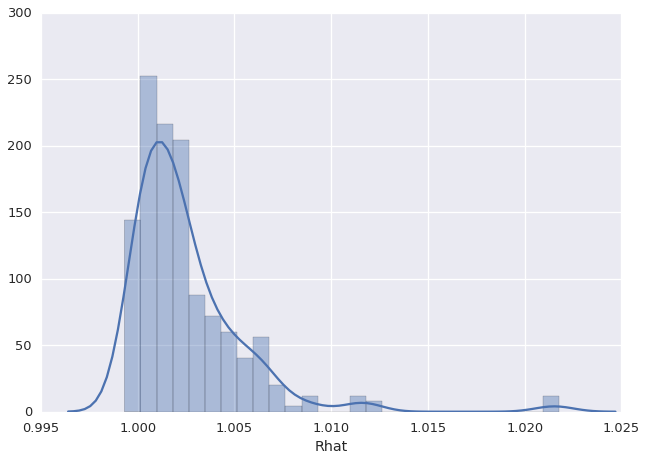

In [9]:
models.plot_stan_summary(model_fit, pars='theta', metric='Rhat')

## summarize posterior draws of theta by gene

In [10]:
# meta-data used for plotting functions below
# so that the following code is invariant to the model run
colnames = list(stan_data['x'].columns)
sort_by = colnames[0]
print(sort_by)

cell_type[B]


In [11]:
theta_ldf = models.prep_theta_summary(model_fit, sample_df=sample_df, colnames=colnames, expose_group=sort_by)

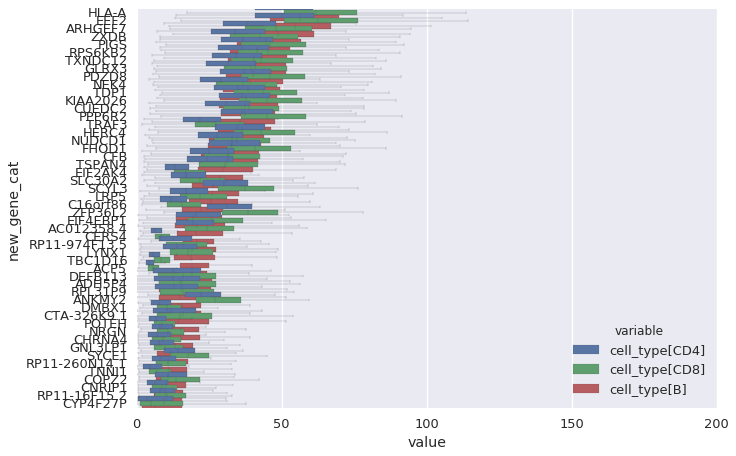

In [12]:
## show theta estimates for first 50 genes, by `sort-by`
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_value_rank_{}'.format(sort_by)] <= 50,:] \
                .sort_values('mean_value_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, width=2, linewidth=0.2)

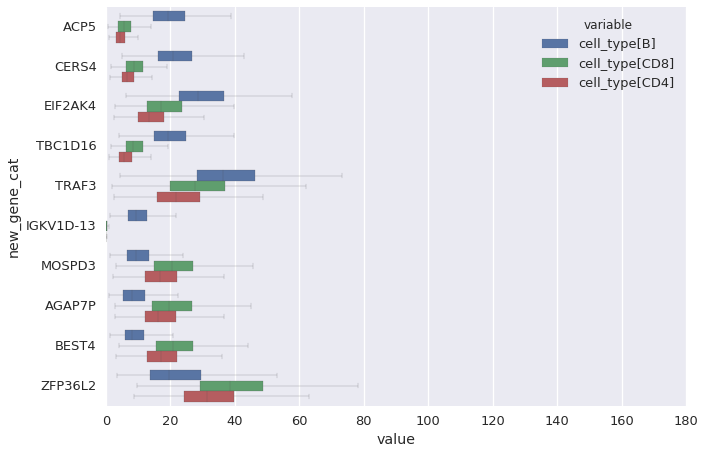

In [13]:
## zoom in on the highest-ranked genes by `sort-by` difference from average 
## across all cell types
g = sns.boxplot(data=theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .sort_values('mean_diff_rank_{}'.format(sort_by)),
            y='new_gene_cat',
            x='value',
            hue='variable', 
            fliersize=0, linewidth=0.2)

## posterior-predictive checking for selected genes

In [14]:
# identify top_genes by name
top_genes = theta_ldf.loc[theta_ldf['mean_abs_diff_rank_{}'.format(sort_by)] <= 10,:] \
                .drop_duplicates(subset='new_gene_cat')['new_gene_cat'].values
print(top_genes)

['ACP5' 'AGAP7P' 'BEST4' 'CERS4' 'EIF2AK4' 'IGKV1D-13' 'MOSPD3' 'TBC1D16'
 'TRAF3' 'ZFP36L2']


In [15]:
# get yrep draws
yrep_df = models.prep_yrep_summary(model_fit, sample_df=sample_df, filter_genes=top_genes[0:3])

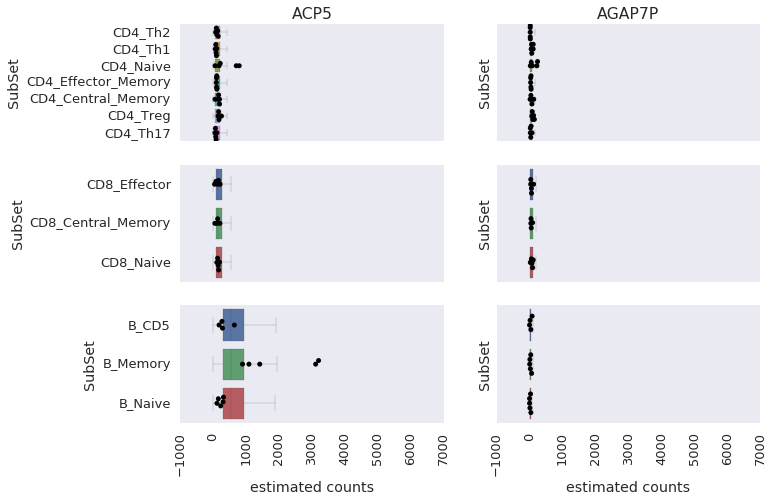

In [16]:
# plot estimates & observed values for top 3 genes, by Subset
models.plot_posterior_predictive_checks(model_fit=model_fit, plot_genes=top_genes, sample_df=sample_df,
                                        yrep_df=yrep_df, n_genes=2)


## summarize posterior draws for `Omega`

In [17]:
omega_summary = models.prep_omega_summary(stan_fit=model_fit, stan_data=stan_data, par='Omega', gene_id=by)

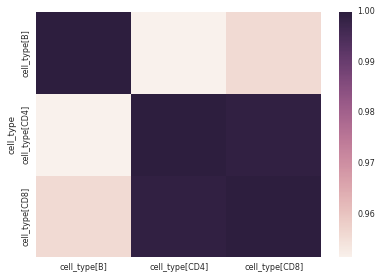

In [18]:
with sns.plotting_context('paper'):
    sns.heatmap(omega_summary.loc[:, list(stan_data['x'].columns)])